# Logistic Regression
## ICE 2025 - Artificial Intelligence for O&G Without the Hype


>  - Complete: <a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/Logistic_regression_1D_2D_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
>
>  - Class: <a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/Logistic_regression_1D_2D_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Pedro Pesce <<pedro_pesce@petrobras.com.br>>
- Thiago Toribio <<thiago.toribio@petrobras.com.br>>
- Cesar Calderon <<cjcalderon@petrobras.com.br>>
- Luiz Eduardo Queiroz <<eduardoqueiroz@petrobras.com.br>>
- Antonio de Padua Pires <<antonio.pires@petrobras.com.br>>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import sklearn.preprocessing as skp
import sklearn.pipeline as skpp
import sklearn.linear_model as skl
import sklearn.metrics as skm
import sklearn.model_selection as skms
import matplotlib.colors as clrs
import warnings
from IPython.display import display_html

cmap = clrs.LinearSegmentedColormap.from_list('train',['green','white','orange'])
cmap_val = clrs.LinearSegmentedColormap.from_list('validation',['lime','white','red'])
palette = ['green','orange']
palette_val = ['lime','red']

def show_2D_model(pipe,X,y,ngrid=61, ax=None, cmap=cmap, make_3d=False, marker='o', clb=True):
    X_arr = np.asarray(X)
    y_arr = np.asarray(y)
    if ax is None:
        if make_3d:
            fig = plt.figure()
            ax = fig.add_subplot(1,1,projection='3d')
        else:
            ax = plt.gca()
    # Defining the grid
    xs_grid = [np.linspace(x.min()-x.std(),x.max()+x.std(),ngrid+i) for (i,x) in enumerate(X_arr.T)]
    Xs_grid = np.meshgrid(*xs_grid)
    X_grid = np.array(Xs_grid).reshape(2,-1).T

    cols = X.columns if hasattr(X,'columns') else None

    df_grid = pd.DataFrame(X_grid,columns=cols) # avoids warning when preprocessing steps have feature names

    y_hat_grid = pipe.predict_proba(df_grid)[:,1].reshape(Xs_grid[0].shape)
    if make_3d:
        ax.scatter(*X_arr.T,y_arr,c=y_arr,marker=marker,cmap=cmap)
    else:
        ax.scatter(*X_arr.T,c=y_arr,marker=marker,cmap=cmap)

    if make_3d:
        CS = ax.plot_surface(*Xs_grid,y_hat_grid,cmap=cmap,alpha=0.4,vmin=0,vmax=1)
    else:
        CS = ax.contourf(*Xs_grid,y_hat_grid,9,cmap=cmap,alpha=0.4,vmin=0,vmax=1)
    ax.contour(*Xs_grid,y_hat_grid,[0.5],colors='k',linestyles='--')
    ax.grid(); ax.set_xlabel(df_grid.columns[0]); ax.set_ylabel(df_grid.columns[1])
    if clb:
        plt.colorbar(CS,ax=ax)
    return ax

def show_1D_points(x_train,y_train,x_val,y_val,ax=None):
    if ax is None:
        ax = plt.gca()
    h = ax.scatter(x_train,y_train,c=y_train,cmap=cmap)
    plt.colorbar(h,ax=ax)
    ax.scatter(x_val  ,y_val  ,c=y_val,cmap=cmap_val,marker='x')
    return ax

def compare_perf(py1_train,py1_validation,py2_train,py2_validation,y_train,y_validation,titles):
    fig,axs = plt.subplots(2,4,sharey='row', figsize=(9,4))
    strip_opts = {'jitter':0.3,'alpha':0.4,'legend':False,'orient':'h'}
    sns.stripplot(x=py1_train[:,1],y=y_train,ax=axs[0,0],
                hue=y_train,palette=palette,**strip_opts)
    sns.stripplot(x=py1_validation[:,1],y=y_validation,ax=axs[0,1],
                hue=y_validation,palette=palette_val,**strip_opts,marker='X',s=8)
    sns.stripplot(x=py2_train[:,1],y=y_train,ax=axs[0,2],
                hue=y_train,palette=palette,**strip_opts)
    sns.stripplot(x=py2_validation[:,1],y=y_validation,ax=axs[0,3],
                hue=y_validation,palette=palette_val,**strip_opts,marker='X',s=8)
    [ax.axvline(x=0.5, color='k', linestyle='--') for ax in axs[0]]
    [ax.set_xlabel('p (sandstone)') for ax in axs[0]]
    axs[0,0].set_ylabel('True facies')
    [ax.set_title(title) for (ax,title) in zip(axs[0],titles)]

    cm_opts = {'fmt':'d','xticklabels':[0,1],'yticklabels':[0,1],'cbar':False,
            'annot':True,'annot_kws':{"size": 14}}
    cm1_train = skm.confusion_matrix(y_train, py1_train[:,1]>0.5)
    cm1_val = skm.confusion_matrix(y_validation, py1_validation[:,1]>0.5)
    cm2_train = skm.confusion_matrix(y_train, py2_train[:,1]>0.5)
    cm2_val = skm.confusion_matrix(y_validation, py2_validation[:,1]>0.5)
    sns.heatmap(cm1_train, cmap='Blues', ax=axs[1,0],**cm_opts)
    sns.heatmap(cm1_val  , cmap='Reds' , ax=axs[1,1],**cm_opts)
    sns.heatmap(cm2_train, cmap='Blues', ax=axs[1,2],**cm_opts)
    sns.heatmap(cm2_val  , cmap='Reds' , ax=axs[1,3],**cm_opts)
    [ax.set_xlabel('Predicted facies') for ax in axs[1]]
    axs[1,0].set_ylabel('True facies')
    fig.tight_layout()
    plt.show()

    cms = [skm.classification_report(y, py[:,1]>0.5,output_dict=True) for (y,py) in zip([y_train,y_validation],[py1_train,py1_validation])] + \
          [skm.classification_report(y, py[:,1]>0.5,output_dict=True) for (y,py) in zip([y_train,y_validation],[py2_train,py2_validation])]
    cms = [pd.DataFrame(cm).transpose() for cm in cms]
    stylers = [df.style.set_table_attributes("style='display:inline'").set_caption(title).format("{:.2f}") for (df,title) in zip(cms,titles)]

    print()
    display_html(''.join([styler._repr_html_() for styler in stylers[:2]]), raw=True)
    print()
    display_html(''.join([styler._repr_html_() for styler in stylers[2:]]), raw=True)

    return fig,axs,cms

## Synthetic dataset

Consider the following dataset, which qualitatively simulates 2 **features** with very different scales (**GR** and **NPHI**), which can be used to classify each example as belonging to facies 1 (sandstone), or 0 (shale).

We will reserve 70% of the dataset for training and 30% for validation.


In [2]:
X,y = sklearn.datasets.make_moons(n_samples=(150,180),noise=0.25,random_state=42)
y = 1-y
X[:,0] = (X[:,0] + 1.5)/7
X[:,1] = -X[:,1]*30 + 50

df = pd.DataFrame(np.column_stack((X,y)), columns=['NPHI', 'GR', 'FACIES'])

df_train,df_validation = skms.train_test_split(df,train_size=0.7,random_state=23)
print(f'{df_train.shape = } ;  {df_validation.shape = }')
df.sample(4)

df_train.shape = (230, 3) ;  df_validation.shape = (100, 3)


,NPHI,GR,FACIES
282,0.134797,11.620478,1.0
311,0.525016,64.031272,0.0
121,0.179877,39.149395,0.0
21,0.305236,23.456557,1.0


Notice how neither feature by itself can unambiguously identify the correct facies, but both together (almost) can:

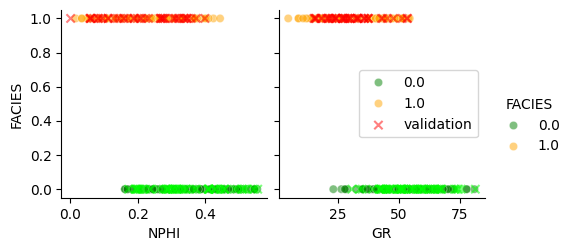

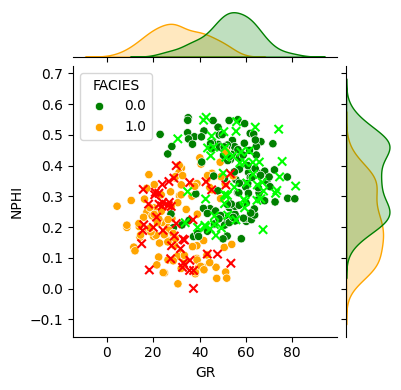

In [3]:
px = sns.pairplot(data=df_train,x_vars=df.columns[:-1],y_vars=['FACIES'], hue='FACIES',
                 plot_kws={'alpha':0.5},palette=palette)
px.axes[0,0].scatter(df_validation['NPHI'],df_validation['FACIES'],c=df_validation['FACIES'],cmap=cmap_val,marker='x',alpha=0.5)
px.axes[0,1].scatter(df_validation['GR'],df_validation['FACIES'],c=df_validation['FACIES'],cmap=cmap_val,marker='x',alpha=0.5,label='validation')
px.axes[0,1].legend()

jx = sns.jointplot(data=df_train,x='GR', y='NPHI',hue='FACIES',height=4,palette=palette)
jx.ax_joint.scatter(df_validation['GR'], df_validation['NPHI'],c=df_validation['FACIES'],cmap=cmap_val,marker='x',label='validation')
plt.show()

# Logistic Regression

We will use a similar strategy to linear regression to estimate the probability $p_{i}$ that example $i$ belongs to the positive class, based on a linear combination of the input **features**. This simple linear combination does not represent a probability, since it can be any number in $(-\infty, \infty)$. It represents a quantity we call the **logit**, or **log-odds**, represented here by $\ell_i$:

$$
\ell_i = \textrm{logit}(p_i) = \ln \left( \frac{p_i}{1-p_i} \right) = w_0 + w_1x_{i1} + \cdots + w_Mx_{iM} = \vec{w} \cdot \vec{x}_i
$$

where, same as previously, it is common to augment the feature vector with a constant feature of value $1$ and the model parameters are called its *bias* and *weights*.

In order to guarantee that the estimated probabilities are between $0$ and $1$, the linear combination will be passed through the **logistic function**, also called **sigmoid** ($\sigma$):

$$
p_i = \sigma\left(\ell_i\right) = \frac{1}{1+e^{-\vec{w} \cdot \vec{x}_i}} = \frac{e^{\vec{w} \cdot \vec{x}_i}}{e^{\vec{w} \cdot \vec{x}_i}+1}
$$

Notice how very negative values of $\ell_i=\vec{w} \cdot \vec{x}_i$ map to probabilities close to $0$, while very positive values map to probabilities close to $1$.

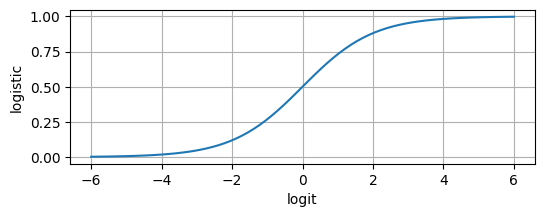

In [4]:
ell = np.linspace(-6,6,71)  # many values, just to look at the plot

def sigmoid(log_odds):
    return 1/(1+np.exp(-log_odds)) # YOUR CODE HERE

plt.figure(figsize=(6,2))
plt.plot(ell,sigmoid(ell))
plt.xlabel('logit'); plt.ylabel('logistic'); plt.grid()

A high performance model should estimate high probability values $(\sigma_i \approx 1)$ for examples belonging to the positive class $(y_i=1)$ and low values otherwise ($\sigma_i \approx 0$ , when $y_i=0$). In other words, we want $\sigma_i \approx y_i$, similar to the previously studied regression problem.

# Single feature model

In order to gain some intuition, let us explore a simplified model where the only input feature is **GR**, that is:

$$
p_i = \sigma(\ell_i) = \frac{1}{1+e^{-\left(w_0 + w_1GR_i \right)}}
$$

where training boils down to obtaining good values for the model's **bias** $(w_0)$ and **weight** $(w_1)$.

Try it out manually, below. Notice how the **bias** $w_0$ shifts the curve laterally, while the **weight** $w_1$ controls how quickly, and in which direction, the curve flips from 0 to 1.

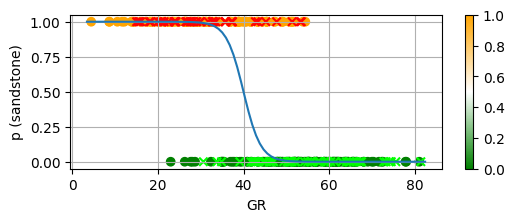

In [5]:
w_0, w_1 = 20, -0.5 # YOUR CODE HERE. Try to estimate good values for the model parameters

gr_ax = np.linspace(df['GR'].min()-1,df['GR'].max()+1,91) # GR values that span the whole axis
p_ax = sigmoid(w_0+w_1*gr_ax)

plt.figure(figsize=(6,2))
show_1D_points(df_train['GR'], df_train['FACIES'], df_validation['GR'],df_validation['FACIES'])
plt.plot(gr_ax,p_ax)
plt.xlabel('GR'); plt.ylabel('p (sandstone)'); plt.grid()

# Z-normalization

Notice how sensitive the predicted facies probabilities are to the specific values of the model parameters. One common strategy to improve this is to center and rescale the features, a procedure known as **z-normalization**. For each feature $x_{ij}$, subtract the **mean** $\mu_j$ and divide the result by the **standard deviation** $s_j$ and use the transformed features $z_{ij}$ as inputs to the model:

$$
z_{ij} = \frac{x_{ij}-\mu_j}{s_j} \qquad ; \qquad \mu_j = \frac{1}{N}\sum_{i=1}^N x_{ij} \qquad ; \qquad
s_j = \sqrt{\frac{1}{N}\sum_{i=1}^N \left(x_{ij}-\mu_j\right)^2}
$$

**Important!** To avoid data leakage from the validation dataset, the **mean** and **standard deviation** values are calculated only over the **training dataset**. These same values are now part of the ML pipeline and must be stores along with the model for future use.

In [6]:
mu_GR  = df_train['GR'].mean() # YOUR CODE HERE. Obtaining statistics for z-norm
std_GR = df_train['GR'].std()  # YOUR CODE HERE. Obtaining statistics for z-norm

z_GR_train = (df_train['GR']-mu_GR)/std_GR  # z-norm for the training dataset
z_GR_validation = (df_validation['GR']-mu_GR)/std_GR # YOUR CODE HERE. z-norm for the validation dataset

z_GR_train = z_GR_train.values # turning into numpy arrays
z_GR_validation = z_GR_validation.values
y_train = df_train['FACIES'].values
y_validation = df_validation['FACIES'].values

Notice how much easier it is to find reasonable parameters with a z-normalized feature:

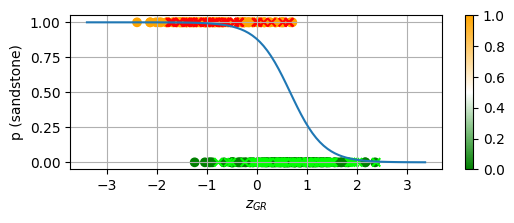

In [7]:
w_0, w_1 = 2, -3 # YOUR CODE HERE. Try to estimate good values for the model parameters

z_ax = np.linspace(z_GR_train.min()-1,z_GR_train.max()+1,91) # GR values that span the whole axis

p_ax = sigmoid(w_0+w_1*z_ax)
plt.figure(figsize=(6,2))
show_1D_points(z_GR_train,y_train, z_GR_validation,y_validation)
plt.plot(z_ax,p_ax)
plt.xlabel('$z_{GR}$'); plt.ylabel('p (sandstone)')
plt.grid()

# Objective functions and loss landscape

A high performance model should output $p_i \approx y_i$. We express this condition in the form of an **objective function**, which can take on several forms. We will explore 2 examples, with different characteristics: **mean squared error** (MSE) and **binary cross-entropy** (H):

$$\begin{align}
MSE(\vec w)   &= \phantom{-}\frac{1}{N}\sum_{i=1}^N \left( p_i-y_i \right)^2 \\
H(\vec w)   &=  -         \frac{1}{N}\sum_{i=1}^N y_i\ln{p_i} + (1-y_i)\ln{(1-p_i)}
\end{align}
$$

For the logistic model, the binary cross-entropy can be written in a mathematically equivalent form which is numerically more stable, since it avoids exponentials with large positive values. However, we use the *logits* $\ell_i$ instead of the predicted probabilities:

$$
H = \dfrac{1}{N}\sum_i \max(0,\ell_i) + \ln\left(1+e^{-|\ell_i|} \right) - y_i\ell_i  \quad ; \quad p_i = \sigma(\ell_i) = \frac{1}{1+e^{-\ell_i}}
$$

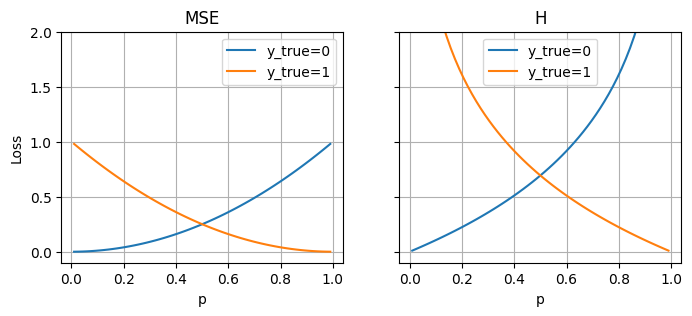

In [8]:
def MSE(p,y, axis=0):
    '''Mean Squared error'''
    return np.mean((p-y)**2, axis=axis) # YOUR CODE HERE

def H(p,y, axis=0):
    '''Naive binary cross-entropy'''
    return -np.mean( y*np.log(p) + (1-y)*np.log(1-p) , axis=axis) # YOUR CODE HERE

def H_from_logits(logit,y, axis=0):
    '''Binary cross entropy (numericaly stable)'''
    return np.mean( np.maximum(0,logit) + np.log(1 + np.exp( -np.abs(logit))) - y*logit , axis=axis)

p_ax = np.linspace(0.01,0.99,61)  # many values
MSE_ax_0 = MSE(p_ax[None,:],y=0); MSE_ax_1 = MSE(p_ax[None,:],y=1)
H_ax_0   = H(p_ax[None,:],y=0)  ; H_ax_1   = H(p_ax[None,:],y=1)

fig,axs = plt.subplots(1,2,figsize=(8,3),sharex='all',sharey='all')
axs[0].plot(p_ax,MSE_ax_0,label='y_true=0'); axs[0].plot(p_ax,MSE_ax_1,label='y_true=1')
axs[1].plot(p_ax,H_ax_0,label='y_true=0')  ;axs[1].plot(p_ax,H_ax_1,label='y_true=1')
axs[0].set_xlabel('p'); axs[0].set_ylabel('Loss'); axs[0].set_title('MSE')
axs[1].set_xlabel('p'); axs[1].set_title('H'); axs[0].set_ylim(-0.1,2)
[ax.legend() for ax in axs]; [ax.grid() for ax in axs];

### Loss landscape

Since our simplified model has only two trainable parameters, it is possible for us to visualize the loss function over a certain region of the parameter space.

Let's plot the $MSE$ and $H$ functions for $w_0 \in [-20,20]$ and $w_1 \in [-15,15]$:

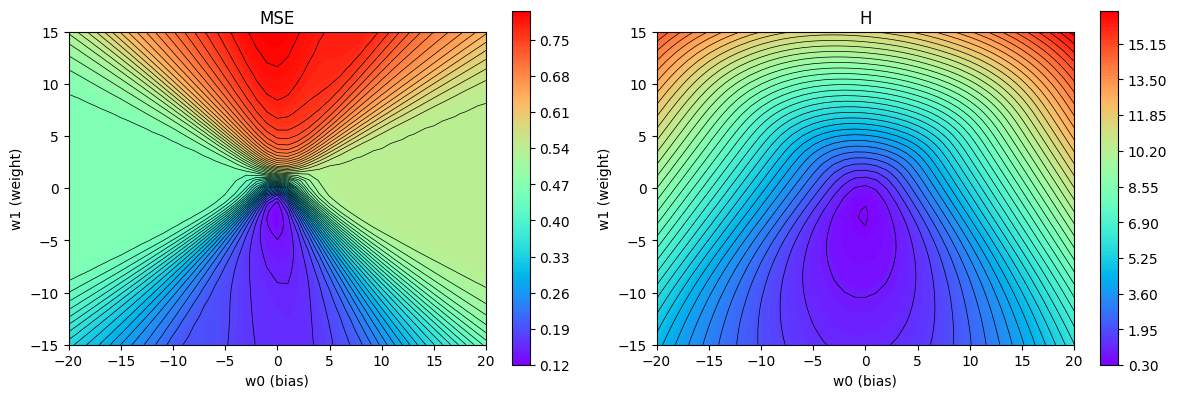

In [9]:
w0_grid = np.linspace(-20,20,41)
w1_grid = np.linspace(-15,15,43)

ww0,ww1 = np.meshgrid(w0_grid,w1_grid)
MSE_grid = np.vectorize( lambda w0,w1: MSE(sigmoid(w0+w1*z_GR_train),y_train) )(ww0,ww1) # No loop
#H_grid   = np.vectorize( lambda w0,w1: H(  sigmoid(w0+w1*z_GR_train),y_train) )(ww0,ww1) # No loop
H_grid   = np.vectorize( lambda w0,w1: H_from_logits(w0+w1*z_GR_train,y_train) )(ww0,ww1) # No loop

plt.figure(figsize=(12,4))

ax = plt.subplot(1,2,1)
plt.contourf(ww0,ww1,MSE_grid,151,cmap='rainbow')
plt.colorbar()
plt.contour(ww0,ww1,MSE_grid,51,colors='k',linewidths=0.5)
plt.xlabel('w0 (bias)'), plt.ylabel('w1 (weight)'), ax.set_aspect(1), plt.title('MSE')

ax2 = plt.subplot(1,2,2,sharex=ax,sharey=ax)
plt.contourf(ww0,ww1,H_grid,151,cmap='rainbow')
plt.colorbar()
plt.contour(ww0,ww1,H_grid,51,colors='k',linewidths=0.5)
plt.xlabel('w0 (bias)'), plt.ylabel('w1 (weight)'), ax2.set_aspect(1), plt.title('H')
plt.axis([w0_grid[0],w0_grid[-1],w1_grid[0],w1_grid[-1]])
plt.tight_layout()
plt.show()

# Optimization procedure

In order to find the optimum model **parameters** (**train** the model), we will make use of the **gradient descent** method, which consists of updating an initial estimate of the model weights acording to the rule:

$$
\begin{align}
\vec{w}^{(1)} & =  \vec{w}^{(0)} - \gamma \vec{\nabla} L(\vec{w}^{(0)}) \\
\vec{w}^{(2)} & =  \vec{w}^{(1)} - \gamma \vec{\nabla} L(\vec{w}^{(1)}) \\
& \, \,  \vdots \\
\vec{w}^{(n)} & =  \vec{w}^{(n-1)} - \gamma \vec{\nabla} L(\vec{w}^{(n-1)})
\end{align}
$$
repeat until $\lVert \vec{\nabla} L(\vec{w}^{(n)}) \rVert < tol$

where $\vec{w}^{(0)}$ is an initial guess of the parameters vector, $\vec{w}^{(n)}$ is the updated parameters vector after the $n$-th iteration, $\vec{\nabla}L$ is the **gradient** of the loss function with respect to the model parameters and $\gamma$ is a **hyperparameter** called the **learning rate**, which is basically a **step-size multiplier**.

In [10]:
def gradient_descent(f_grad,w,args=(),gamma=1e-2,tol=1e-5,maxiter=2000):
    ''' Gradient descent for multivariate optimization.

    Inputs:
    -----------
        f_grad: function that returns the objective function gradient. f_grad(w, *args) -> float array
        w: initial estimate for the optimum parameters
        args: extra arguments for f_grad. (Optional)
        gamma: step size multiplier
        tol: optimization stops when ||f_grad(w)|| < tol
        maxiter: maximum number of iterations

    Outputs:
    -----------
        w_opt: parameterr that minimizes function
        history: np.array that stores all steps taken
    '''
    grad = f_grad(w,*args) # Gradient at starting point
    history = [w]
    for it in range(int(maxiter)):
        w = w - gamma*grad  # Update rule
        grad = f_grad(w,*args)  # new gradient
        history.append(w)

        if (np.linalg.norm(grad)<tol): # halting criterion
            break
    else: # only runs if the loop exhausts range(maxiter) wihtout triggering the break command
        warnings.warn(f'Did not converge after {it+1} iterations. Try different parameters.')

    return w, np.array(history)

## Gradients

Writing each loss function explicitly in terms of the parameters:

$$\begin{align}
MSE(\vec w)   &= \phantom{-}\frac{1}{N}\sum_{i=1}^N \Bigl[ \sigma(\overbrace{w_0+w_1x_i}^{\ell_i})-y_i \Bigr]^2 \\
H(\vec w)   &=  -         \frac{1}{N}\sum_{i=1}^N y_i\ln{\Bigl[\sigma(w_0+w_1x_i)\Bigr]} + (1-y_i)\ln{\Bigl[1-\sigma(w_0+w_1x_i)\Bigr]}
\end{align}
$$

Each partial derivative can be found with a repeated application fo the chain rule:

For MSE:
$$\begin{align}
\frac{\partial MSE}{\partial w_j} &= \frac{1}{N}\sum_i 2\Bigl[ \sigma(\ell_i)-y_i \Bigr]
\quad \frac{d \sigma(\ell_i)}{d \ell_i} \quad
\frac{\partial \ell_i}{\partial w_j} \\
\frac{\partial MSE}{\partial w_j} &=
\frac{1}{N}\sum_i 2\Bigl[ \sigma(\ell_i)-y_i \Bigr]
\sigma(\ell_i) \Bigl[ 1 - \sigma(\ell_i) \Bigr]
x_{ij} \end{align}
$$

$$
\frac{\partial MSE}{\partial w_j} =  
\frac{1}{N}\sum_i 2 \, (p_i-y_i) \, \, p_i \, \,  (1 - p_i) \, x_{ij}
$$

For the binary cross-entropy:

$$\begin{align}
\frac{\partial H}{\partial w_j} &= -\frac{1}{N}\sum_i
y_i \frac{1}{\sigma(\ell_i)}
\quad \frac{d \sigma(\ell_i)}{d \ell_i} \quad
\frac{\partial \ell_i}{\partial w_j} \quad+
(1-y_i) \frac{(-1)}{1-\sigma(\ell_i)}
\quad \frac{d \sigma(\ell_i)}{d \ell_i} \quad
\frac{\partial \ell_i}{\partial w_j} \\
\frac{\partial H}{\partial w_j} &= -\frac{1}{N}\sum_i
y_i \frac{1}{\sigma(\ell_i)}
\sigma(\ell_i) \Bigl[1-\sigma(\ell_i) \Bigr]
x_{ij} -
(1-y_i) \frac{1}{1-\sigma(\ell_i)}
\sigma(\ell_i) \Bigl[1-\sigma(\ell_i) \Bigr]
x_{ij}  \end{align}
$$

$$
\frac{\partial H}{\partial w_j} = \frac{1}{N}\sum_i (p_i-y_i)x_{ij}
$$

In [11]:
def grad_MSE(w,x,y):
    '''Gradient for MSE of logistic function with a single feature'''
    w0,w1 = w
    p = sigmoid(w0+w1*x)
    dMSE_dw0 = np.mean( 2*(p-y)*p*(1-p)   )
    dMSE_dw1 = np.mean( 2*(p-y)*p*(1-p)*x ) # YOUR CODE HERE
    return np.array([dMSE_dw0, dMSE_dw1])

def grad_H(w,x,y):
    '''Gradient for cross-entropy of logistic function with a single feature'''
    w0,w1 = w
    p = sigmoid(w0+w1*x)
    dMSE_dw0 = np.mean( (p-y)   ) # YOUR CODE HERE
    dMSE_dw1 = np.mean( (p-y)*x ) # YOUR CODE HERE
    return np.array([dMSE_dw0, dMSE_dw1])

Try out a few optimization runs with different parameters. Notice how the binary cross-entropy loss function, with its single well defined minimum, is much easier to optimize. Contrast with MSE and its flat regions, where $\vec{\nabla} L$ is close to zero, such that gradient descent either halts prematurely, or makes only **very** slow progress.

/tmp/ipython-input-514865949.py:28: UserWarning: Did not converge after 200 iterations. Try different parameters.
  warnings.warn(f'Did not converge after {it+1} iterations. Try different parameters.')


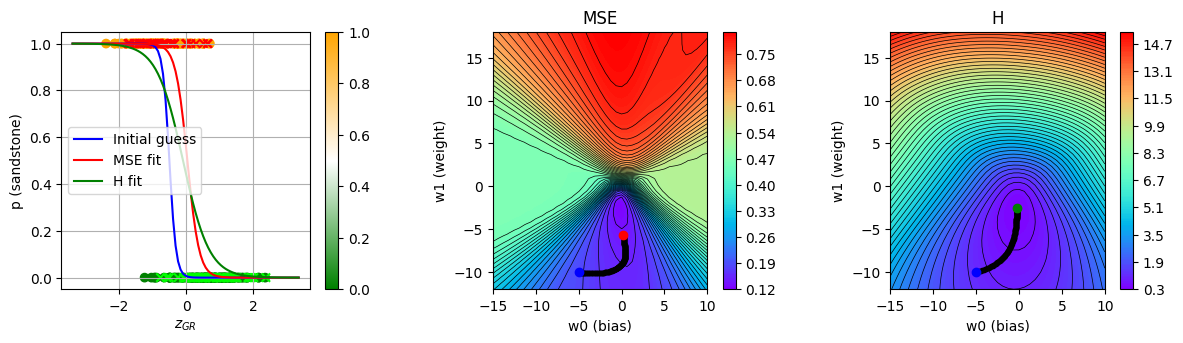

In [23]:
w_0, w_1 = 5, -3 # YOUR CODE HERE. Try to estimate good values for the model parameters
w_0, w_1 = -5,-10  # Alternative guesses
# w_0, w_1 = -10, 10  # Alternative guesses
gamma   = 10 # learning rate
tol     = 1e-4 # numerical tolerance for "almost zero" gradient. Optimization halts if ||grad||<tol
maxiter = 200 # maximum number of iterations

(w0_MSE,w1_MSE),hist_MSE = gradient_descent(grad_MSE,(w_0,w_1),(z_GR_train,y_train),gamma=gamma, tol=tol, maxiter=maxiter)
(w0_H,w1_H),hist_H = gradient_descent(grad_H,(w_0,w_1),(z_GR_train,y_train), gamma=gamma/10, tol=tol, maxiter=maxiter)

if True:
    w0_grid = np.linspace(-15,10,41)
    w1_grid = np.linspace(-12,18,43)

    ww0,ww1 = np.meshgrid(w0_grid,w1_grid)
    MSE_grid = np.vectorize( lambda w0,w1: MSE(sigmoid(w0+w1*z_GR_train),y_train) )(ww0,ww1) # No loop
    #H_grid   = np.vectorize( lambda w0,w1: H(  sigmoid(w0+w1*z_GR_train),y_train) )(ww0,ww1) # No loop
    H_grid   = np.vectorize( lambda w0,w1: H_from_logits(w0+w1*z_GR_train,y_train) )(ww0,ww1) # No loop

    plt.figure(figsize=(12,3.5))
    plt.subplot(1,3,1)
    show_1D_points(z_GR_train,y_train,z_GR_validation,y_validation)
    plt.plot(z_ax,sigmoid(w_0    + w_1*z_ax   ),color='b',label='Initial guess')
    plt.plot(z_ax,sigmoid(w0_MSE + w1_MSE*z_ax),color='r',label='MSE fit')
    plt.plot(z_ax,sigmoid(w0_H   + w1_H*z_ax  ),color='g',label='H fit')
    plt.xlabel('$z_{GR}$'); plt.ylabel('p (sandstone)')
    plt.legend(loc='center left'), plt.grid()

    ax = plt.subplot(1,3,2)
    plt.contourf(ww0,ww1,MSE_grid,151,cmap='rainbow')
    plt.colorbar()
    plt.contour(ww0,ww1,MSE_grid,51,colors='k',linewidths=0.5)
    plt.plot(*hist_MSE.T,'k.:'); plt.plot(w_0, w_1,'bo'); plt.plot(w0_MSE, w1_MSE,'ro')
    plt.xlabel('w0 (bias)'), plt.ylabel('w1 (weight)'), ax.set_aspect(1), plt.title('MSE')

    ax2 = plt.subplot(1,3,3,sharex=ax,sharey=ax)
    plt.contourf(ww0,ww1,H_grid,151,cmap='rainbow')
    plt.colorbar()
    plt.contour(ww0,ww1,H_grid,51,colors='k',linewidths=0.5)
    plt.plot(*hist_H.T,'k.:'); plt.plot(w_0, w_1,'bo'); plt.plot(w0_H, w1_H,'go')
    plt.xlabel('w0 (bias)'), plt.ylabel('w1 (weight)'), ax2.set_aspect(1), plt.title('H')
    plt.axis([w0_grid[0],w0_grid[-1],w1_grid[0],w1_grid[-1]])
    plt.tight_layout()
    plt.show()

# Adding more features

Now that we have some intuition about how a logistic regression model works, let's train a more capable model that makes use of both **GR** and **NPHI**.

## Model pipeline

All the following steps will be encapsulated within a `skpp.Pipeline` object, created with `skpp.make_pipeline`.

### $z$-normalization

This is especially important when dealing with features that have very different scales, such as **GR** (dozens of units) and **NPHI** (fractions of a unit).

Available via `skp.StandardScaler`.

### Feature engineering

Since our dataset is (almost) separable, but not **linearly** separable, it might be useful to create polynomial features with `skp.PolynomialFeatures`. Let's compare a **linear model** and one with **degree 6** polynomial features.

### Logistic regression

We will use the Scikit-Learn implementation available via `skl.LogisticRegression`.

In [13]:
pipe1 = skpp.make_pipeline(skp.StandardScaler(), # YOUR CODE HERE.  Z-norm
                           skl.LogisticRegression(penalty=None,max_iter=1_000) ) # YOUR CODE HERE. Logistic regression. penalty=None,max_iter=1_000

pipe2 = skpp.make_pipeline(skp.StandardScaler(), # YOUR CODE HERE.  Z-norm
                           skp.PolynomialFeatures(degree=6,include_bias=False), # YOUR CODE HERE.  Polynomial features. include_bias=False
                           skl.LogisticRegression(penalty=None,max_iter=1_000) ) # YOUR CODE HERE. Logistic regression. penalty=None,max_iter=1_000
display(pipe2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=6, include_bias=False)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, penalty=None))])

### Training and inference

Training is done with `pipe.fit` and inference with `pipe.predict_proba` (returns proabilities for each facies), or `pipe.predict` (returns the most likely facies).

In [14]:
features = ['GR', 'NPHI']
X_train = df_train[features] # DataFrame with only the features, including their names
y_train = df_train['FACIES']

X_validation = df_validation[features]
y_validation = df_validation['FACIES']

pipe1.fit(X_train,y_train)  # YOUR CODE HERE. Training the linear model
pipe2.fit(X_train,y_train)  # YOUR CODE HERE. Training the model with polynomial features

py1_train = pipe1.predict_proba(X_train) # INFERENCE with the linear model
py2_train = pipe2.predict_proba(X_train) # INFERENCE with the polynomial features model
py1_validation = pipe1.predict_proba(X_validation)
py2_validation = pipe2.predict_proba(X_validation)

pd.DataFrame(np.column_stack([py1_validation, py2_validation, y_validation]),
             columns=['Model 1 Prob class 0', 'Model 1 Prob class 1',
                      'Model 2 Prob class 0', 'Model 2 Prob class 1','True Facies']).sample(4)

,Model 1 Prob class 0,Model 1 Prob class 1,Model 2 Prob class 0,Model 2 Prob class 1,True Facies
91,0.998821,0.001179,0.000000,1.000000e+00,0.0
89,0.993284,0.006716,1.000000,1.242956e-161,0.0
86,0.980211,0.019789,1.000000,3.931089e-18,0.0
71,0.890001,0.109999,0.991147,8.853019e-03,0.0


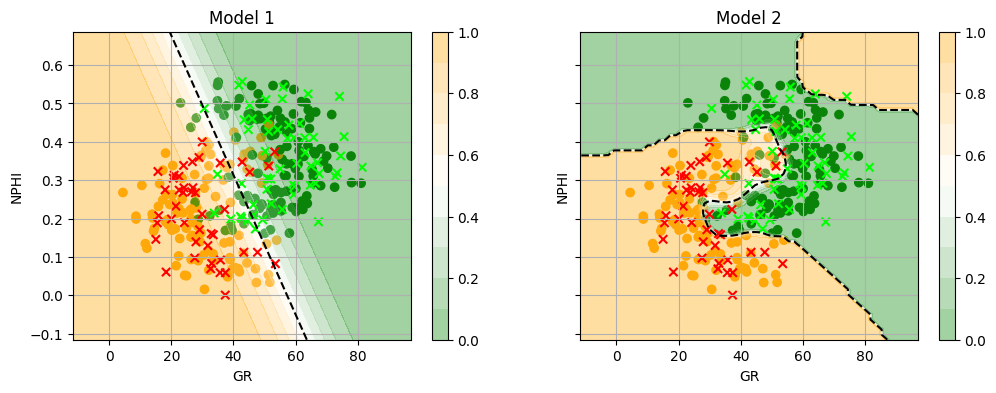

In [15]:
fig,axs = plt.subplots(1,2,sharex='all',sharey='all', figsize=(12,4))

show_2D_model(pipe1,X=X_train, y=y_train, ax=axs[0])
axs[0].scatter(X_validation['GR'],X_validation['NPHI'],c=y_validation, cmap=cmap_val, marker='x')
axs[0].set_title('Model 1')

show_2D_model(pipe2,X=X_train, y=y_train, ax=axs[1])
axs[1].scatter(X_validation['GR'],X_validation['NPHI'],c=y_validation, cmap=cmap_val, marker='x')
axs[1].set_title('Model 2')
plt.show()

If our model had more than two features, the previous visualization would not be possible. However, we can always check how the model's predictions and the ground truth labels compare. A few common ways of doing this are illustrated below, along with the most common metrics:

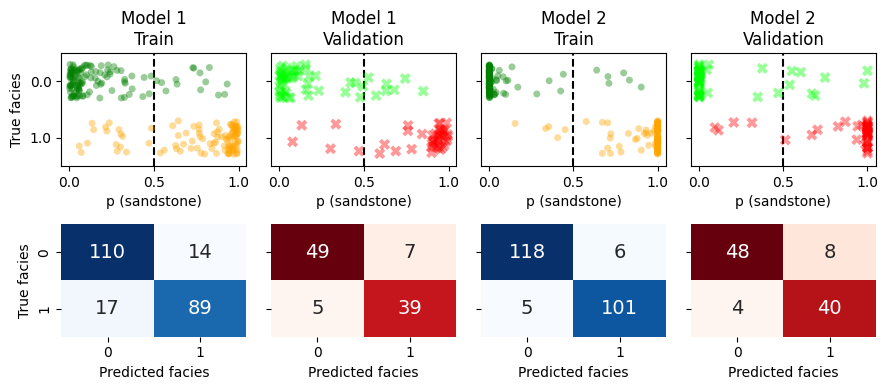

,precision,recall,f1-score,support
0.0,0.87,0.89,0.88,124.00
1.0,0.86,0.84,0.85,106.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.87,0.86,0.86,230.00
weighted avg,0.87,0.87,0.87,230.00
,precision,recall,f1-score,support
0.0,0.91,0.88,0.89,56.00
1.0,0.85,0.89,0.87,44.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.88,0.88,0.88,100.00


,precision,recall,f1-score,support
0.0,0.96,0.95,0.96,124.00
1.0,0.94,0.95,0.95,106.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.95,0.95,0.95,230.00
weighted avg,0.95,0.95,0.95,230.00
,precision,recall,f1-score,support
0.0,0.92,0.86,0.89,56.00
1.0,0.83,0.91,0.87,44.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.88,0.88,0.88,100.00


In [16]:
titles = ['Model 1\nTrain','Model 1\nValidation','Model 2\nTrain','Model 2\nValidation']

compare_perf(py1_train,py1_validation,py2_train,py2_validation,y_train,y_validation,titles);

# Under and Overfitting

Notice how the linear model **underfits** the data. It is not sufficiently flexible to conform to our complicated dataset. We say it is a **high bias** model. This can be solved by using a more flexible model, such as one with higher degree polynomial features.

On the other hand, the model with polynomial features of degree 6 **overfits** the data. It is a model with **high variance**. Notice also how the model's weights are numerically large.

In [17]:
print(f'Model 1 weights: {np.round(pipe1["logisticregression"].coef_, 2)}')
print(f'Model 2 weights: {np.round(pipe2["logisticregression"].coef_, 2)}')

Model 1 weights: [[-2.39 -1.07]]
Model 2 weights: [[ -4.38   3.22   4.63  13.38 -12.95   4.45  28.74 -18.41  13.62 -12.24
  -11.1  -13.35 -16.02  11.58 -12.25  -1.48 -20.99 -19.52  25.31 -17.12
   -0.63  12.93   3.95  12.86   3.17   1.27   1.76]]


## Regularization

One strategy for mitigating overfitting is called **regularization**, that is, changing the objective function to account for more than just the data **misfit**, but also penalizing some other characteristic of a complex model. In our case, we'll penalize **large weights**.

The objective function that `skl.LogisticRegression` optimizes is the following:

$$
L = \underbrace{\sum_{i=1}^N\Bigl( y_i\ln(p_i) + (1-y_i)\ln(1-p_i) \Bigr)}_{\textrm{misfit}} + \frac{1}{C}\underbrace{\lVert \vec{w} \rVert^2}_{\textrm{"complexity"}}
$$

where $C$ is the **regularization hyperparameter**. Large values of $C$ lead to an objective funtion that cares only about the model's misfit (low regularization regime, high variance, low bias), while low values of $C$ lead to an objective function that heavily penalizes large values for the weights (high regularization regime, high bias, low variance).

As with other hyperparameters, the best value for $C$ is not found by optimizing the objective function, but rather by estimating which value will lead to the best **performance** when the model is presented with **novel data**. In our workflow, the **validation dataset** is a proxy for this unseen data.

The default performance metric for `skl.LogisticRegression` is the model's **accuracy**, that is, the fraction of correct predictions over a given dataset.

We will test 16 values of $C$ ranging from $10^{-2}$ to $10^3$:

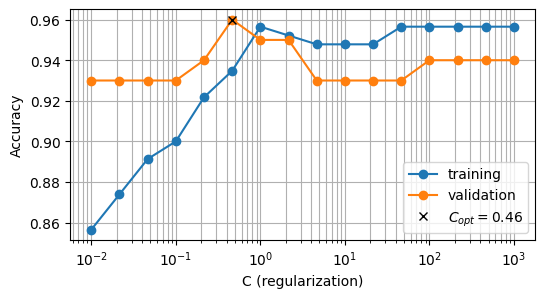

In [31]:
n_Cs = 16  # number of different values to try
Cs = np.logspace(-2,3,n_Cs) # C changes by several orders of magnitude

pipes = [None]*n_Cs # inicializing with the correct size
accuracy_train = np.zeros(n_Cs)
accuracy_validation = np.zeros(n_Cs)

for i,C in enumerate(Cs):
    pipes[i] = skpp.make_pipeline(skp.StandardScaler()                               , # YOUR CODE HERE for z-normalization
                                  skp.PolynomialFeatures(degree=6,include_bias=False), # YOUR CODE HERE for polynomial features
                                  skl.LogisticRegression(C=C, max_iter=10_000)       ) # YOUR CODE HERE for classifier. max_iter=10_000
    pipes[i].fit(X_train,y_train) # YOUR CODE HERE to train the i-th model

    accuracy_train[i] = pipes[i].score(X_train,y_train)
    accuracy_validation[i] = pipes[i].score(X_validation,y_validation)

best_idx = np.argmax(accuracy_validation) # YOUR CODE HERE. Which dataset helps us choose the best C?
best_pipe = pipes[best_idx]

plt.figure(figsize=(6,3))
plt.semilogx(Cs,accuracy_train,'o-',label='training')
plt.semilogx(Cs,accuracy_validation,'o-',label='validation')
plt.plot(Cs[best_idx],accuracy_validation[best_idx],'xk',label=f'$C_{{opt}}={Cs[best_idx]:.2f}$')
plt.xlabel('C (regularization)'), plt.ylabel('Accuracy'), plt.legend()
plt.grid(which='both')

### Visualizing the regularized models

Since the trained models use only 2 features, we can visualize them in feature space. Notice how over-regularized model **underfit** the data, while under-regularized models **overfit** the data:

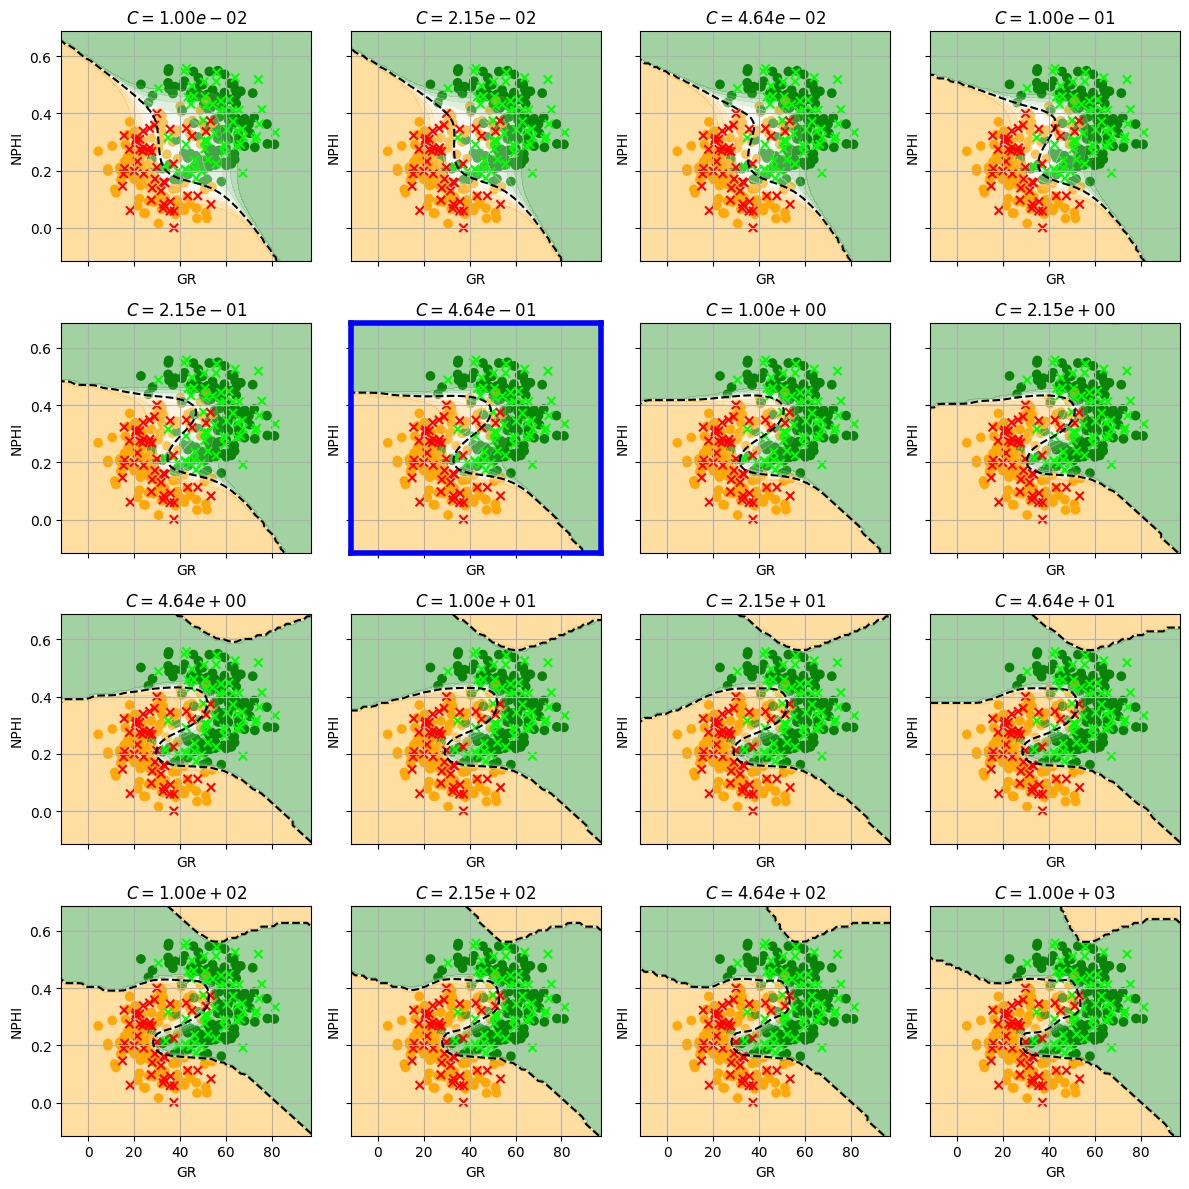

In [32]:
nlin = int(np.sqrt(n_Cs))
ncol = int(np.ceil(n_Cs/nlin))
fig,axs = plt.subplots(nlin,ncol,figsize=(12,12),sharex='all',sharey='all')
axs = axs.ravel()
for idx,(C,ax,pipe,ACC_t,ACC_v) in enumerate(zip(Cs,axs,pipes,accuracy_train,accuracy_validation)):
    show_2D_model(pipe,X=X_train, y=y_train, ax=ax, clb=False)
    ax.scatter(X_validation['GR'],X_validation['NPHI'],c=y_validation, cmap=cmap_val, marker='x')
    ax.set_title(f'$C={C:.2e}$')
    if idx == best_idx:
        ax.spines[:].set_color('b')
        ax.spines[:].set_linewidth(4)

plt.tight_layout()
plt.show()

Notice how the regularized model's weights are considerably smaller than those of the unregularized model, while maintaining high performance on the training dataset **and better** performance on the validation dataset:

In [33]:
print('Unregularized model weights:')
print(pipe2['logisticregression'].coef_)
print()
print('Best regularized model weights:')
print(best_pipe['logisticregression'].coef_)

Unregularized model weights:
[[ -4.37817939   3.22470668   4.63394339  13.38487263 -12.94625388
    4.45015155  28.73675409 -18.40963461  13.61656215 -12.23972231
  -11.0957194  -13.35164807 -16.02232119  11.5787534  -12.24823853
   -1.48224972 -20.99172006 -19.51951658  25.30662217 -17.11983538
   -0.63369561  12.92923069   3.94833657  12.85934887   3.16660794
    1.2670965    1.76050508]]

Best regularized model weights:
[[-1.2366649   1.56589919 -0.1979948  -0.11684382 -0.08231857 -0.7937532
  -0.06483736 -0.03831468 -0.24251106 -0.16528255  0.04919117 -0.11525542
  -0.01322088  0.07745072 -0.66046773 -0.32243498 -0.04532546 -0.4772564
   0.18656533 -1.22271165 -0.07328822  0.19820239 -0.14420678  0.19588321
  -0.08537072  0.06502454  0.13991968]]


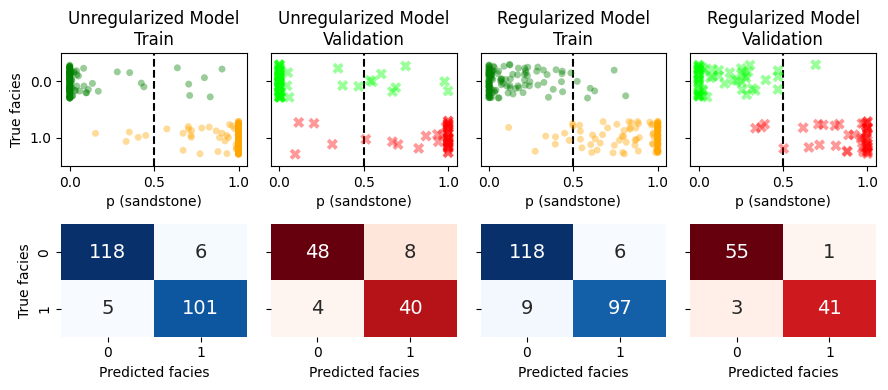

,precision,recall,f1-score,support
0.0,0.96,0.95,0.96,124.00
1.0,0.94,0.95,0.95,106.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.95,0.95,0.95,230.00
weighted avg,0.95,0.95,0.95,230.00
,precision,recall,f1-score,support
0.0,0.92,0.86,0.89,56.00
1.0,0.83,0.91,0.87,44.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.88,0.88,0.88,100.00


,precision,recall,f1-score,support
0.0,0.93,0.95,0.94,124.00
1.0,0.94,0.92,0.93,106.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.94,0.93,0.93,230.00
weighted avg,0.93,0.93,0.93,230.00
,precision,recall,f1-score,support
0.0,0.95,0.98,0.96,56.00
1.0,0.98,0.93,0.95,44.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.96,0.96,0.96,100.00


In [35]:
py_best_train = best_pipe.predict_proba(X_train)
py_best_validation = best_pipe.predict_proba(X_validation)
final_titles = ['Unregularized Model\nTrain','Unregularized Model\nValidation',
                'Regularized Model\nTrain','Regularized Model\nValidation']
compare_perf(py2_train,py2_validation,py_best_train,py_best_validation,y_train,y_validation,final_titles);